<a href="https://colab.research.google.com/github/JulijanaMilosavljevic/loan-prediction/blob/main/loan_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Imports and Setup**

In [1]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# **2. Load Dataset**

In [3]:
# Load CSV
df = pd.read_csv('loan.csv')

# Quick look
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


# **3. Data exploration**
- Check shape, info and missing values
- Summary statistics for numeric columns
- Look at distribution of target (Loan_Status)


(614, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB
Loan_ID               0
Gender               13
Married               3
Dependents           15
Educat

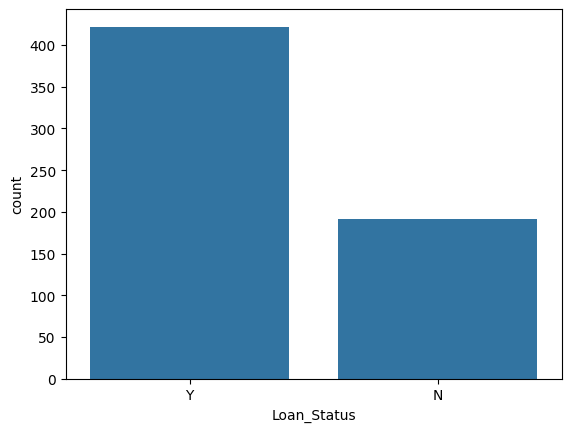

In [4]:
# Shape and info
print(df.shape)
df.info()

# Missing values
print(df.isnull().sum())

# Summary stats
df.describe()

# Target distribution
sns.countplot(data=df, x='Loan_Status')
plt.show()


# **4. Data Cleaning & Feature Engineering**
- Replace missing values
- Convert categorical variables
- Add derived features: TotalIncome, DebtToIncome
- Log transform skewed variables

In [5]:
# Replace '?' with NaN
df.replace('?', np.nan, inplace=True)

# Convert numeric columns
for col in ['LoanAmount','ApplicantIncome','CoapplicantIncome','Loan_Amount_Term']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert target to binary
df['Loan_Status'] = df['Loan_Status'].map({'Y':1,'N':0})

# Impute numeric with median
for col in df.select_dtypes(include=[np.number]).columns:
    df[col].fillna(df[col].median(), inplace=True)

# Impute categorical with mode
for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Feature engineering
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['LogTotalIncome'] = np.log1p(df['TotalIncome'])
df['DebtToIncome'] = df['LoanAmount'] / df['TotalIncome']
df['DebtToIncome'].fillna(0, inplace=True)

# Binning LoanAmount
df['LoanAmountBin'] = pd.qcut(df['LoanAmount'], 4, duplicates='drop').astype(str)

# Dependents numeric
df['Dependents'] = df['Dependents'].replace('3+',3).astype(float)

df.head()


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome,LogTotalIncome,DebtToIncome,LoanAmountBin
0,LP001002,Male,No,0.0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,1,5849.0,8.674197,0.021884,"(100.25, 128.0]"
1,LP001003,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0,6091.0,8.714732,0.021015,"(100.25, 128.0]"
2,LP001005,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1,3000.0,8.006701,0.022000,"(8.999, 100.25]"
3,LP001006,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1,4941.0,8.505525,0.024287,"(100.25, 128.0]"
4,LP001008,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1,6000.0,8.699681,0.023500,"(128.0, 164.75]"


# **5. Prepare features and target**

In [6]:
# Define numeric and categorical columns
numeric_cols = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','TotalIncome','LogTotalIncome','DebtToIncome','Dependents']
categorical_cols = ['Gender','Married','Education','Self_Employed','Property_Area','LoanAmountBin','Credit_History']  # Credit_History can be categorical

X = df[numeric_cols + categorical_cols]
y = df['Loan_Status']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# **6. Build preprocessing pipeline**

In [7]:
# Preprocessing
num_transformer = Pipeline([('scaler', StandardScaler())])
cat_transformer = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer([
    ('num', num_transformer, numeric_cols),
    ('cat', cat_transformer, categorical_cols)
])


# **7. Baseline Logistic Regression**

In [8]:
# Pipeline
pipe = Pipeline([
    ('preproc', preprocessor),
    ('clf', LogisticRegression(max_iter=500))
])

# Fit
pipe.fit(X_train, y_train)

# Predict
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:,1]

# Evaluation
print("Logistic Regression Report")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


Logistic Regression Report
              precision    recall  f1-score   support

           0       0.90      0.42      0.57        43
           1       0.76      0.97      0.85        80

    accuracy                           0.78       123
   macro avg       0.83      0.70      0.71       123
weighted avg       0.81      0.78      0.75       123

ROC-AUC: 0.7488372093023256


# **8. Random Forest with GridSearch**

In [9]:
# Random Forest with GridSearch
param_grid = {
    'clf__n_estimators':[100,200],
    'clf__max_depth':[None,5,10]
}

pipe_rf = Pipeline([
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(random_state=42))
])

grid = GridSearchCV(pipe_rf, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
y_pred_rf = grid.predict(X_test)
y_proba_rf = grid.predict_proba(X_test)[:,1]

print("Random Forest Report")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))


Best params: {'clf__max_depth': None, 'clf__n_estimators': 200}
Random Forest Report
              precision    recall  f1-score   support

           0       0.85      0.51      0.64        43
           1       0.78      0.95      0.86        80

    accuracy                           0.80       123
   macro avg       0.81      0.73      0.75       123
weighted avg       0.81      0.80      0.78       123

ROC-AUC: 0.7550872093023255


# **9. Evaluation plots**

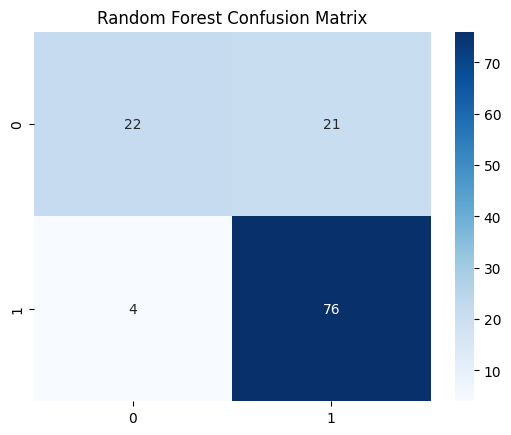

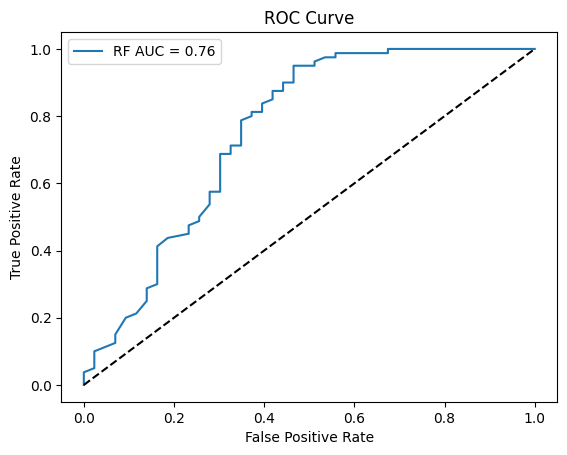

In [10]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
plt.plot(fpr, tpr, label='RF AUC = %.2f' % auc(fpr,tpr))
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
